## Kaggle Titanic
### feat2/wip
This branch is modified from feat1. Changes are
    - Drop the name feature in addition to passengerID (it seem redundancy)

In [1]:
%%bash
git branch

  cost1/feat1/wip
  cost1/feat2/wip
  cost1/wip
  feat1/score1/wip
  feat1/wip
  feat2/score1/wip
* feat2/wip
  feat3/wip
  feat4/wip
  feat5/wip
  master


In [1]:
%%bash
git add 'Titanic.ipynb'
git add 'Test_data.ipynb'
git commit -m 'Finish testing (added test feature for matching purpose)'
git push --set-upstream origin feat2/wip

[feat2/wip 7175585] Fixed the code in model file to ensure proper feature matching in test data
 2 files changed, 1796 insertions(+), 1686 deletions(-)
 rewrite Test_data.ipynb (85%)
Branch feat2/wip set up to track remote branch feat2/wip from origin.


To github.com:Theerit/Kaggle_Titanic.git
   d6a0307..7175585  feat2/wip -> feat2/wip


As usual, import all neccasary stuff into the notebook

### filename string for saving trained model

In [2]:
# save the model to disk
filename = 'feat2.sav'

In [3]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 
import sklearn.model_selection
import pickle

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, I will start by loading the data in panda dataframe and do some EDA.

In [4]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#Concate train and test to avoid mismatch features in the testing phase
#train_objs_num = len(train)
#dataset = pd.concat(objs=[train, test], axis=0)
#dataset = pd.get_dummies(dataset)
#train = dataset[:train_objs_num].copy()
#test = dataset[train_objs_num:].copy()
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [6]:
X = train.copy()
#X = X.drop('Survived',axis=1)
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
X = X.drop('Name',axis=1) # Drop the name 

#Do what we did to X dataframe to test
test = test.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
test = test.drop('Name',axis=1)

Y = pd.DataFrame(train['Survived'])

### Label Class Distribution
Lets take a look at class (Survived) distribution, the distribution is slightly skew where more passengers didn't survive.

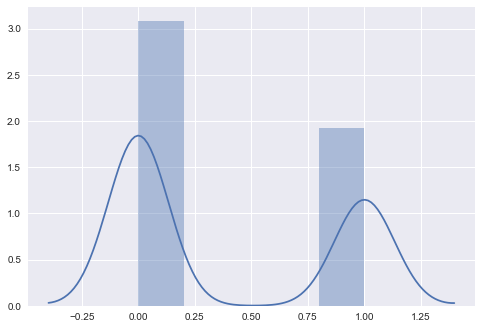

In [7]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Sanitizing data, finding all NaN data in X

In [8]:
X.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

So Age,Cabin and Embarked have NaN value. This version consider keeping them.

### Numerical Distribution Plots
Take a look at each numerical atrributes distribution.

ValueError: cannot convert float NaN to integer

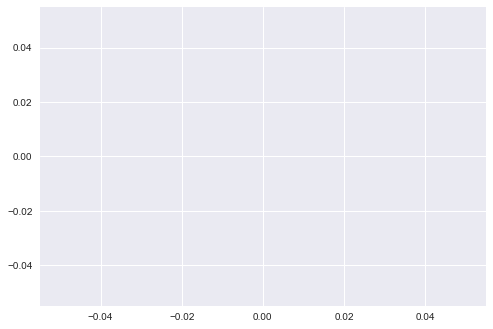

In [9]:
#Divide Numerical and Categorical attributes
#Pclass is actually categorical
num_attri = ['Age','SibSp','Parch','Fare']
cat_attri = [column for column in X if (column not in num_attri and column != 'Survived')]
#print(num_attri)
#print(cat_attri)
#Plot numerical variables
for i,column in enumerate(num_attri):
    #print(column)
    plt.figure(i)
    sns.distplot(X[column])

### Categorical Bar Plots
Now, for categorical attributes, make a bar plot.

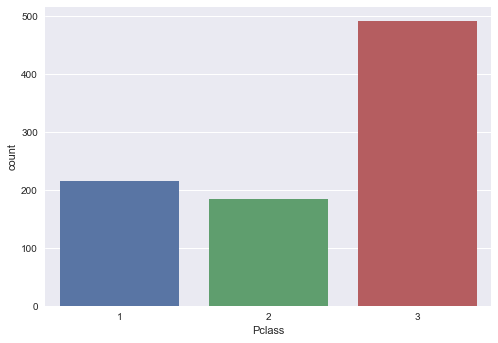

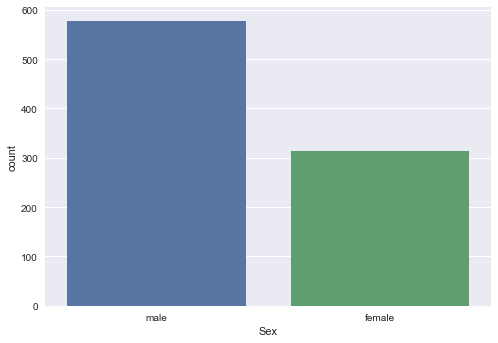

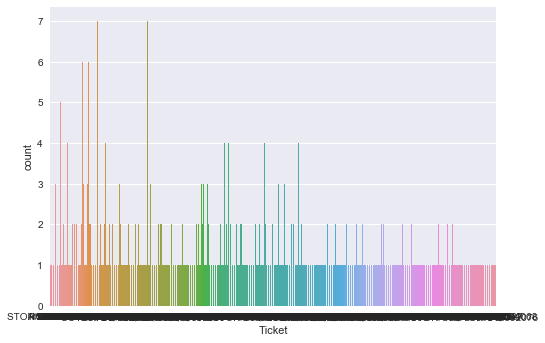

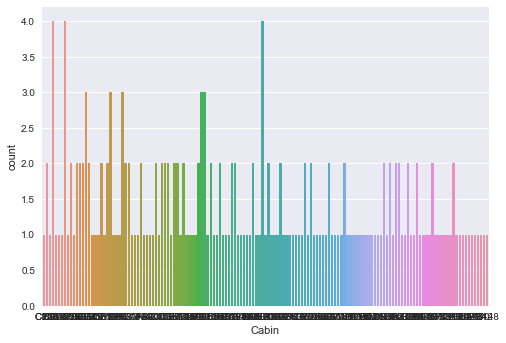

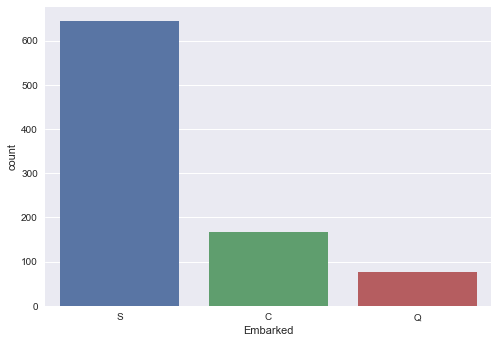

In [10]:
for i,column in enumerate(cat_attri):
    #Lets just keep every categorical attributes for plotting
    plt.figure(i)
    sns.countplot(X[column])

Observation: Majority of Pclass is class 1. Name, as one might expected, is equally distributed (one count for each name). Sex count is equal. Some spikes in Ticket and Cabin. Very small Q (Queenstown) counts for Embarked.

### Pairplot
Make a pairplot for all numerical variables

ValueError: max must be larger than min in range parameter.

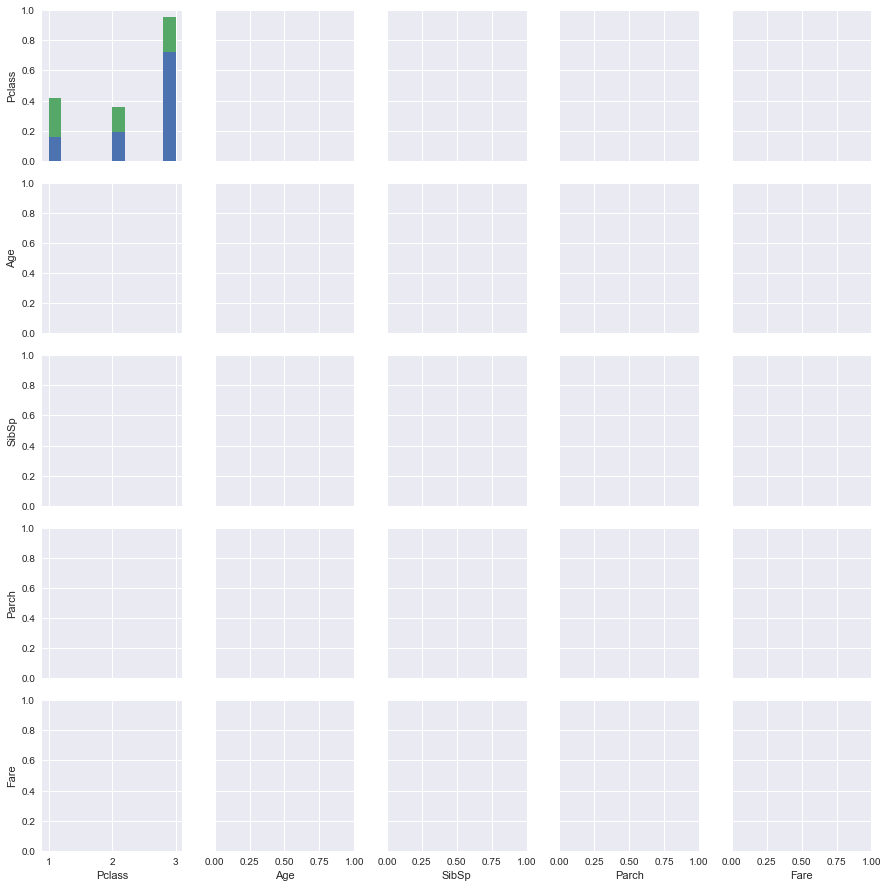

In [12]:
# Make new dataframe for pairplot purpose
X_pairplot = X.copy()
X_pairplot.loc[X_pairplot['Survived']==1,'Survived'] = 'Survived'
X_pairplot.loc[X_pairplot['Survived']==0,'Survived'] = 'Not Survived'

#X_pairplot[Survived=0] = 'Not Survived'

#Add Survived category to numerical attributes for plotting purpose
if 'Survived' not in num_attri:
    num_attri = num_attri + ['Survived']
    
g = sns.pairplot(X_pairplot,hue='Survived')

### Dummy Variables
For starter, create dummy variables for categorical features.

In [13]:
for column in (cat_attri): #Create dummy for X
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)
    
for column in (cat_attri): #Create dummy for test
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(test[column],prefix=column)
    test.drop(column,axis=1,inplace=True)
    test = test.join(tempDF)

#Concat X(train data) with X from test data to avoid mismatch feature
train_objs_num = len(X)
dataset = pd.concat(objs=[X, test], axis=0)
#dataset = pd.get_dummies(dataset)
X = dataset[:train_objs_num].copy()
test = dataset[train_objs_num:].copy()


In [14]:
X.head()

,Age,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,...,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,22.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0,0,0.0,0,0.0,0.0
1,38.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0,0,0.0,0,0.0,0.0
2,26.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0,0,0.0,0,0.0,0.0
3,35.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0,0,0.0,0,0.0,0.0
4,35.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0,0,0.0,0,0.0,0.0


### Feature Evaluation
For starter using random forest to evaluate feature importance.
Code shamelessly brought from:http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [15]:
#Format dataframe for scikit training
y = X['Survived']
X.drop('Survived',axis=1,inplace=True)

Start with numerical feature ranking first

In [16]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Evaluate CV with AUC, but will also consider Accuracy performance of the model.

In [18]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

clf = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        )
# specify parameters via map
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': np.arange(1,11,1),
              'subsample': np.arange(0.1,0.9,0.1).tolist(),
              'colsample_bytree': np.arange(0.5,0.9,0.1).tolist()}
clf = GridSearchCV(clf, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='roc_auc',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 4 folds for each of 320 candidates, totalling 1280 fits
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.5s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.2s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.2s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.2s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.2s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.3s
[CV] objective=binary:logistic, subsa

[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed: 16.7min finished


In [19]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.864663170633
Best Param:{'objective': 'binary:logistic', 'subsample': 0.4, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'max_depth': 8}


Now considering accuracy performance of the model on CV set.

In [20]:
clf2 = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        colsample_bytree = best_param_4CV['colsample_bytree'],
        learning_rate = best_param_4CV['learning_rate'],
        max_depth =  best_param_4CV['max_depth'],
        objective = best_param_4CV['objective'],
        subsample = best_param_4CV['subsample']
        )
clf2.fit(X_train,y_train)
# save the model to disk
pickle.dump(clf2, open(filename, 'wb'))
 
from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.89606741573


Performance on test set.

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.821235521236
Test set Accuracy:0.832402234637


Taking a look at confusion matrix. Code brought from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Confusion matrix, without normalization
[[93 12]
 [18 56]]
Normalized confusion matrix
[[ 0.88571429  0.11428571]
 [ 0.24324324  0.75675676]]


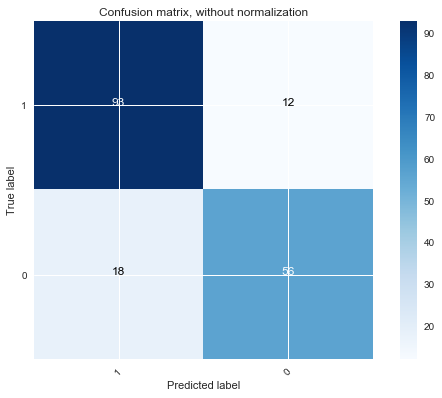

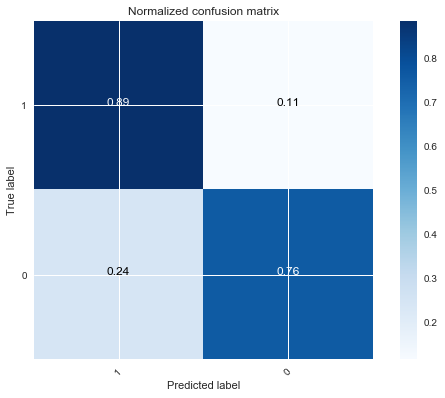

In [22]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_test, clf2.predict(X_test))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,0],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=([1,0]), normalize=True,
                      title='Normalized confusion matrix')
plt.show()